Click this button to run in Colab.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ssuai/deep_learning_from_scratch/blob/master/ch05/back_prop_two_layer_net.ipynb)

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sys, os

In [2]:
# some helper functions for Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False
    
if is_colab():
    !git clone --filter=blob:none --sparse https://github.com/ssuai/deep_learning_from_scratch.git
    %cd deep_learning_from_scratch
    !git sparse-checkout set dataset common ch05
else:        
    sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

## 5.7.2 오차역전파법을 적용한 신경망 구현하기

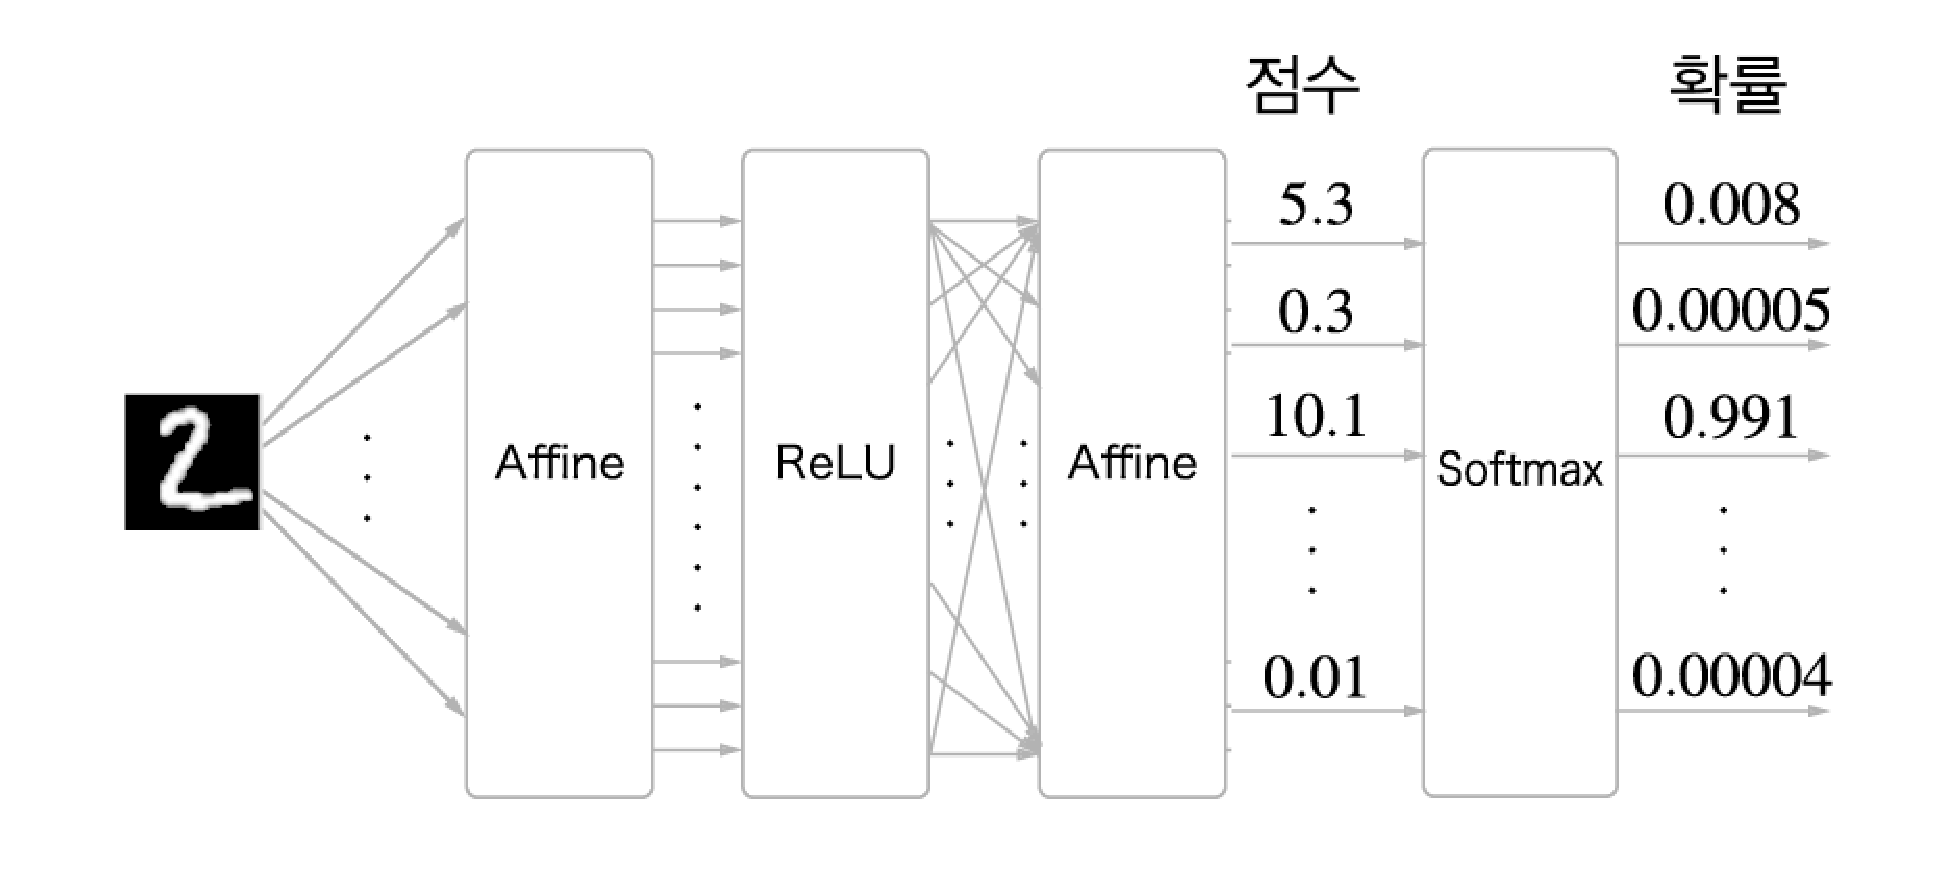

In [3]:
# two_layer_net.py
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## 5.7.4 오차역전파법을 사용한 학습 구현하기

In [4]:
# train_neuralnet.py
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.10248333333333333 0.0994
0.9015833333333333 0.9034
0.9228833333333334 0.9268
0.9381166666666667 0.9375
0.9471166666666667 0.9445
0.95245 0.9477
0.9577166666666667 0.9544
0.9605666666666667 0.9588
0.9645666666666667 0.9624
0.9676666666666667 0.9641
0.9694666666666667 0.9652
0.9703166666666667 0.9649
0.9738 0.9663
0.9753166666666667 0.9692
0.9757833333333333 0.9685
0.9773 0.9691
0.9795 0.9701


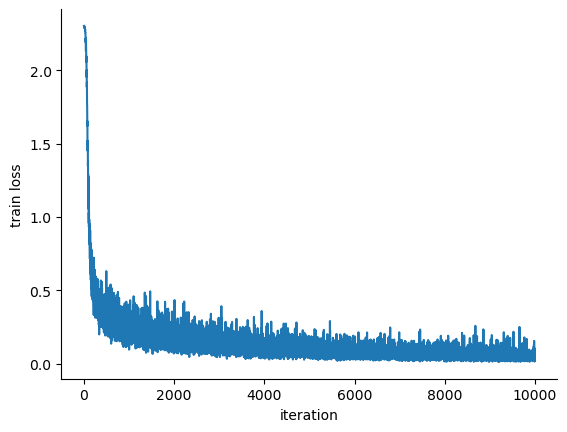

In [5]:
plt.plot(train_loss_list)
plt.ylabel('train loss')
plt.xlabel('iteration')
sns.despine()

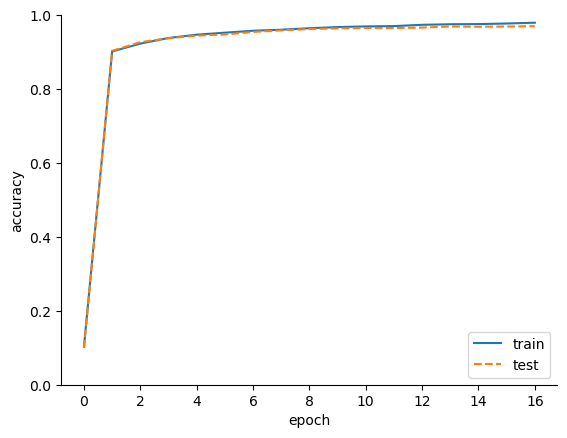

In [6]:
# 정확도 그래프
plt.plot(train_acc_list, label='train')
plt.plot(test_acc_list, label='test', linestyle='--')
plt.ylim(0, 1.0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
sns.despine()